# Softmax exercise

*ATTENTION: When hand in your homework, all print info has to be kept which means that output results of each cell could be seen in your submissions. Homework scores will be judged by those print info. So show us the best result in your experiment. More details can be found in assignment1_tutor.pdf.

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [61]:
import random
import numpy as np
from MS325.datasets.fashion_mnist.utils import mnist_reader
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
def get_mnist_data(num_training=58000, num_validation=2000, num_test=10000, num_dev=1000):
    """
    Load the Fashion_mnist dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw Fashion_mnist data
    X_train, y_train = mnist_reader.load_mnist('MS325/datasets/fashion_mnist/data/fashion', kind='train')
    X_test, y_test = mnist_reader.load_mnist('MS325/datasets/fashion_mnist/data/fashion', kind='t10k')
    X_train = X_train.astype(np.float64)
    #y_train = y_train.astype(np.float64)
    X_test = X_test.astype(np.float64)
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0).astype('uint8')
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_mnist_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (58000, 785)
Train labels shape:  (58000,)
Validation data shape:  (2000, 785)
Validation labels shape:  (2000,)
Test data shape:  (10000, 785)
Test labels shape:  (10000,)
dev data shape:  (1000, 785)
dev labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **MS325/classifiers/softmax.py**. 


In [63]:
# First implement the naive softmax loss function with nested loops.
# Open the file MS325/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from MS325.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(785, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.312995
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Because we randomly initialize it and the total of classes is 10, so the loss is -log(0.1)


In [64]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from MS325.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.017777 analytic: -0.179223, relative error: 1.000000e+00
numerical: 7.895761 analytic: -12.487239, relative error: 1.000000e+00
numerical: 2.033000 analytic: -6.795001, relative error: 1.000000e+00
numerical: -6.501878 analytic: 7.176121, relative error: 1.000000e+00
numerical: -0.000025 analytic: 0.097974, relative error: 1.000000e+00
numerical: 0.039090 analytic: -0.391910, relative error: 1.000000e+00
numerical: 9.990056 analytic: -11.148944, relative error: 1.000000e+00
numerical: -0.531471 analytic: -0.252472, relative error: 3.558925e-01
numerical: 0.368356 analytic: -0.002644, relative error: 1.000000e+00
numerical: -5.980932 analytic: 3.885068, relative error: 1.000000e+00
numerical: -13.141926 analytic: 8.346073, relative error: 1.000000e+00
numerical: -0.003439 analytic: -0.010439, relative error: 5.043934e-01
numerical: 2.773226 analytic: -5.242775, relative error: 1.000000e+00
numerical: -0.519920 analytic: -1.673920, relative error: 5.260186e-01
numerical: 5.6

In [65]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from MS325.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.312995e+00 computed in 0.152524s
vectorized loss: 2.312995e+00 computed in 0.006100s
Loss difference: 0.000000
Gradient difference: 873.784883


In [66]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.65 on the validation set.
from MS325.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]            # Modify it as you wish
regularization_strengths = [2.5e4, 5e4]  # Modify it as you wish

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        train = softmax.train(X_train, y_train, lr, rs, 3000)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax           
        results[(lr,rs)] = train_accuracy, val_accuracy
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.720086 val accuracy: 0.713500
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.698000 val accuracy: 0.692000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.722276 val accuracy: 0.715000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.693500 val accuracy: 0.686500
best validation accuracy achieved during cross-validation: 0.715000


In [67]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.721200


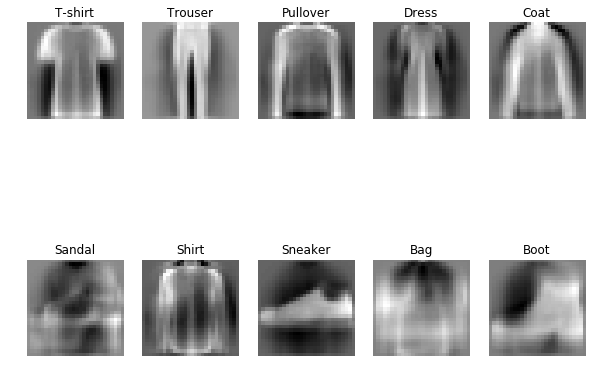

In [68]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(28,28, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])